## UK natural gas system price prediction project

The purpose of this project is to investigate how well machine learning can predict a commodity price, given just a few market fundamentals, and previous prices, as features. I have chosen the UK natural gas market because the key data on supply, demand and prices are freely available and up to date via https://data.nationalgas.com/

The goal is to predict the next day's daily System Average Price and System Marginal (Buy and Sell) Prices. The System Average Price is the volume weighted average price of trades on the UK natural gas On-the-Day Commodity Market - i.e. gas for immediate delivery. The System Marginal Price (Buy) is related to the day's highest price, and is the price that suppliers must pay for the balance of gas used by their customers, if that is more than the amount they have supplied to the system (a "short imbalance") The System Marginal Price (Sell) is related to the day's lowest price. The System Marginal Price (Sell) is related to the day's lowest price, and is the price that suppliers receive for any surplus gas that they have supplied to the system, which their customers have not used (a "long imbalance"). All prices are in pence per kilowatt-hour (p/kWh).

The dataset is drawn from the five year history available at https://data.nationalgas.com/, focusing on the fields that make up the Daily Summary Report, with the data for the three target prices coming from the Prices section of the same data portal.

Model performance will be measured based on Root Mean Squared Error (RMSE), as compared to the RMSE of a naive predictor that simply assumes that the next day's price will be the same as the current day's price. RMSE has been chosen as most suitable to price prediction because it penalises larger errors more harshly than smaller ones.

### Initial setup steps

First we'll make sure the required libraries are available

In [88]:
import requests
import datetime
import time
import pandas as pd
import numpy as np
import joblib

from pathlib import Path

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
#!pip install scikit-optimize # needed on Google Colab
from skopt import BayesSearchCV
from skopt.space import Real, Integer

from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow.keras import layers, models


Initial steps if running on Google Colab, to download support files from GitHub and set the working directory. This includes the data from nationalgas.com in csv format, and also "PUB ids.txt" which is the list of data item IDs to download from nationalgas.com to refresh with the latest data.

In [89]:
#for running on Colab
!git clone https://github.com/MBWestcott/gas-forecast.git

# 2. Change into the repo directory
%cd /content/gas-forecast/notebooks



fatal: destination path 'gas-forecast' already exists and is not an empty directory.
/content/gas-forecast/notebooks


### Get the data
Download in csv format from nationalgas.com if not already present locally

In [90]:
raw_data_folder = Path("../data/raw/")

def download_csv(url, output_file):
    """
    Downloads a CSV file from the given URL and saves it to the specified file.

    :param url: URL to download the CSV data from.
    :param output_file: Path to the local file where the CSV will be saved.
    """
    try:
        # Send a GET request to the URL
        response = requests.get(url)
        response.raise_for_status()  # Ensure we notice bad responses

        # Write the content (CSV data) to a file in binary mode
        with open(output_file, 'wb') as f:
            f.write(response.content)

        print(f"CSV file has been successfully downloaded and saved as '{output_file}'.")

    except requests.HTTPError as http_err:
        print(f"HTTP error occurred: {http_err}")
    except Exception as err:
        print(f"An error occurred: {err}")


def download_raw_data():
    pubIdsFile = Path("../PUB ids.txt")
    with open(pubIdsFile) as f:
        pubIds = f.read()
        pubIds = pubIds.replace("\n", ",").strip()

    download_from = datetime.date.today().replace(day=1) # start first download on first day of current month
    download_to = datetime.date.today() # end first download on today's date
    earliest = download_from.replace(year = download_from.year - 5) # Download data going back 5 years
    while(download_from > earliest):

        # Format the date in yyyy-mm-dd format for the download URL
        formatted_from = download_from.strftime("%Y-%m-%d")
        formatted_to = download_to.strftime("%Y-%m-%d")

        csv_url = f"https://data.nationalgas.com/api/find-gas-data-download?applicableFor=Y&dateFrom={formatted_from}&dateTo={formatted_to}&dateType=GASDAY&latestFlag=Y&ids={pubIds}&type=CSV"
        month_format = download_from.strftime("%Y-%m")
        output_filename = raw_data_folder /  f"{month_format}.csv"

        download_csv(csv_url, output_filename)
        time.sleep(2) # brief courtesy sleep
        download_to = download_from - datetime.timedelta(days=1) # next download should go up to the day before the previous download start date
        download_from = download_to.replace(day=1) # next download should start on the first day of the month

# Do the download if the raw data is not there already
csvCount = sum(1 for f in raw_data_folder.iterdir() if f.is_file() and f.suffix == '.csv')
if(csvCount < 60):
    download_raw_data()

### Load the data

Load the raw CSVs into a single dataframe, and pivot it so that each column represents a feature.
Rename the Applicable At date field to Gas Day, and rename the three price columns that are going to be reused for ground truth and time series

In [91]:
price_targets = ["SAP", "SMPBuy", "SMPSell"]

def pivot(df : pd.DataFrame, cols):

    #only keep the values we are interested in
    mask = df["Data Item"].isin(cols)

    df_filtered = df[mask]

    # if there are duplicates for the field and gas day, take the latest
    df_latest = (
        df_filtered
        .sort_values("Applicable At")
        .groupby(["Gas Day", "Data Item"])
        .last()  # this takes the row with the highest (i.e. latest) "Applicable At" per group
        .reset_index()
    )

    # pivot to get 1 row per gas day
    df_latest = df_latest.pivot(index="Gas Day", columns="Data Item", values="Value").reset_index()

    df_latest = df_latest.sort_values("Gas Day", ascending=True)

    return df_latest

def load_data():
    #Read raw CSVs
    pathlist = list(Path(raw_data_folder).rglob('*.csv'))
    file_count = len(pathlist)
    dfs = []
    files_done = 0
    for path_obj in pathlist:
        path = str(path_obj)

        df = pd.read_csv(path,
            parse_dates=["Applicable At", "Applicable For", "Generated Time"],
            dayfirst=True)

        df.rename(columns={'Applicable For': 'Gas Day'}, inplace=True)
        df['Gas Day'] = pd.to_datetime(df['Gas Day'], dayfirst=True)
        # pivot to 1 row per gas day, with features as columns

        daily_cols = df["Data Item"].unique()

        df_daily = pivot(df, daily_cols)
        dfs.append(df_daily)

        files_done += 1
        if files_done % 10 == 0:
            print(f"Processed {files_done} of {file_count} raw files")

    df = pd.concat(dfs)

    #Rename the columns that are going to be reused for ground truth and time series
    df.rename(columns={"SAP, Actual Day": 'SAP', "SMP Buy, Actual Day": 'SMPBuy', "SMP Sell, Actual Day": 'SMPSell'}, inplace=True)
    return df

df = load_data()
df.to_csv(Path("../data/processed/pivoted.csv"), index=False)
df.info()

Processed 10 of 60 raw files
Processed 20 of 60 raw files
Processed 30 of 60 raw files
Processed 40 of 60 raw files
Processed 50 of 60 raw files
Processed 60 of 60 raw files
<class 'pandas.core.frame.DataFrame'>
Index: 1819 entries, 0 to 29
Data columns (total 45 columns):
 #   Column                                                    Non-Null Count  Dtype         
---  ------                                                    --------------  -----         
 0   Gas Day                                                   1819 non-null   datetime64[ns]
 1   Aggregate LNG Importations - Daily Flow                   1816 non-null   float64       
 2   Beach Including Norway - Daily Flow                       1816 non-null   float64       
 3   Beach and IOG - Beach Delivery                            1815 non-null   float64       
 4   Beach and IOG - Daily Flow                                1816 non-null   float64       
 5   Composite Weather Variable - Actual                       1554 

### Preprocess data

Add the previous 5 days' prices as lag features, and 7- and 30-day rolling averages and standard deviations. Also add day of week features, and a cyclical coding of the day of year for seasonality.

In [92]:
def preprocess(df: pd.DataFrame, add_lags=True, add_labels=True):

    """Deal with missing values, add lagged features, rolling averages and stds, Day of Week, and cyclic encoding for seasonality"""

    if add_lags:
        lag_days = 5
        for i in range(1, lag_days+1):
            for pt in price_targets:
                df[f"{pt} D-{i}"] = df[pt].shift(i)

        # add rolling averages and stds
        for pt in price_targets:
            for window in [7, 30]:
                df[f'{pt} D{window} roll mean'] = (
                    df[pt]
                    .shift(1)               # so today's feature doesn't include today's price
                    .rolling(window=window, min_periods=1)
                    .mean()
                    )
                df[f'{pt} D{window} roll std'] = (
                    df[pt]
                    .shift(1)               # so today's feature doesn't include today's price
                    .rolling(window=window, min_periods=1)
                    .std()
                )

    # add day of week
    df['Day of Week'] = df['Gas Day'].dt.weekday
    df['Is Weekday'] = (df['Gas Day'].dt.weekday < 5).astype(int)
    df['Next Day Is Weekday'] = ((df['Gas Day'] + pd.Timedelta(days=1)).dt.weekday < 5).astype(int)
    # cyclic encoding for seasonality
    df['Day of Year'] = df['Gas Day'].dt.dayofyear
    df['sin_DoY'] = np.sin(2 * np.pi * df['Day of Year'] / 365)
    df['cos_DoY'] = np.cos(2 * np.pi * df['Day of Year'] / 365)

    if add_labels:
        # Add labels for next day's actuals
        for pt in price_targets:
            df[f"Next Day {pt}"] = df[pt].shift(-1)

    return df

df = preprocess(df)
df.to_csv(Path("../data/processed/preprocessed.csv"), index=False)
df.head()

Data Item,Gas Day,Aggregate LNG Importations - Daily Flow,Beach Including Norway - Daily Flow,Beach and IOG - Beach Delivery,Beach and IOG - Daily Flow,Composite Weather Variable - Actual,Composite Weather Variable - Cold,Composite Weather Variable - Normal,Composite Weather Variable - Warm,Demand - Cold,...,SMPSell D30 roll std,Day of Week,Is Weekday,Next Day Is Weekday,Day of Year,sin_DoY,cos_DoY,Next Day SAP,Next Day SMPBuy,Next Day SMPSell
0,2023-03-01,101.17213,193.39144,289.75007,289.75007,4.7185,0.05,5.19,8.78,373.0,...,NaN,2,1,1,60,0.858764,0.512371,4.3259,4.4017,4.2762
1,2023-03-02,102.40084,178.97046,278.66490,278.66490,4.8114,0.13,5.27,8.81,371.0,...,NaN,3,1,1,61,0.867456,0.497513,4.2215,4.2712,4.1718
2,2023-03-03,100.82581,178.18139,276.21710,276.21710,4.5910,0.28,5.24,8.86,362.0,...,0.053104,4,1,0,62,0.875892,0.482508,4.3246,4.3829,4.2749
3,2023-03-04,90.68593,175.35741,261.17944,261.17944,4.5119,0.42,5.33,8.91,334.0,...,0.053848,5,0,0,63,0.884068,0.467359,4.3304,4.3801,4.2807
4,2023-03-05,93.87372,183.05199,272.12691,272.12691,4.1302,0.56,5.42,8.96,328.0,...,0.052817,6,0,1,64,0.891981,0.452072,4.0239,4.0736,3.8080


### Clean missing values and outliers

Most of the missing values are missing "Composite Weather Variable - Actual" from 2020-21. These affect around 15% of the dataset. The best way to fill in those is with the Normal forecast, which should usually be the closest. Apart from that there are very few missing readings so it is feasible to discard any remaining rows with missing data (done at the end, to avoid introducing discrepancies into the lag features)

Also remove outliers where any of the prices was 0, and one of the next day prices was more than 50% away from the current day's price

In [93]:
def clean(df: pd.DataFrame, remove_outliers=True):
    # fill missing CWV actuals with the normal forecast
    df['Composite Weather Variable - Actual'] = df['Composite Weather Variable - Actual'].fillna(df['Composite Weather Variable - Normal'])

    # There should be very remaining few rows that have any NaNs so we can drop any that do
    df.dropna(inplace=True)

    # Can drop the composite weather forecasts
    df.drop(columns=["Composite Weather Variable - Normal", "Composite Weather Variable - Cold", "Composite Weather Variable - Warm"], inplace=True)

    if(remove_outliers):
        for pt in price_targets:
            # remove outliers where any of the prices was 0
            print(df.shape)
            df = df[df[pt] != 0]
            print(df.shape)
            df = df[df[f"Next Day {pt}"] != 0]
            print(df.shape)
            #... and where the next day price is more than 50% away from the current day's price
            df = df[abs(df[pt] - df[f"Next Day {pt}"])/df[pt] < 0.5]
            print(df.shape)
    return df

df = clean(df)
df.to_csv(Path("../data/processed/preprocessed_and_cleaned.csv"), index=False)
df.head()

(1796, 78)
(1796, 78)
(1796, 78)
(1756, 78)
(1756, 78)
(1756, 78)
(1756, 78)
(1751, 78)
(1751, 78)
(1750, 78)
(1749, 78)
(1729, 78)


Data Item,Gas Day,Aggregate LNG Importations - Daily Flow,Beach Including Norway - Daily Flow,Beach and IOG - Beach Delivery,Beach and IOG - Daily Flow,Composite Weather Variable - Actual,Demand - Cold,"Demand - Cold, (excluding interconnector and storage)",Demand - Warm,"Demand - Warm, (excluding interconnector and storage)",...,SMPSell D30 roll std,Day of Week,Is Weekday,Next Day Is Weekday,Day of Year,sin_DoY,cos_DoY,Next Day SAP,Next Day SMPBuy,Next Day SMPSell
5,2023-03-06,91.54251,174.45865,261.27206,261.27206,4.3371,362.0,356.0,237.0,231.0,...,0.050855,0,1,1,65,0.899631,0.436651,4.1450,4.3334,4.0953
6,2023-03-07,96.08944,154.70322,246.07896,246.07896,3.6134,359.0,353.0,236.0,230.0,...,0.182506,1,1,1,66,0.907014,0.421101,4.0816,4.2652,4.0319
7,2023-03-08,101.88258,159.40560,256.65888,256.65888,2.1014,357.0,351.0,234.0,228.0,...,0.168904,2,1,1,67,0.914128,0.405426,4.0005,4.2986,3.9508
8,2023-03-09,98.50054,166.21177,260.05311,260.05311,2.7251,355.0,349.0,232.0,226.0,...,0.162634,3,1,1,68,0.920971,0.389630,4.4084,4.4581,4.3587
9,2023-03-10,106.32239,167.04690,268.66439,268.66439,2.9351,345.0,339.0,223.0,217.0,...,0.165003,4,1,0,69,0.927542,0.373720,4.5827,4.6324,4.4528


### Split the data into training, test and validation sets
Experimenting with two configurations:
- Split the data sequentially by date - earliest portion to train, then later portion to validate, and the last to test. Designed to test whether the model will generalise to the most recent period, despite having been trained on earlier periods
- Split the data randomly regardless of date

Decisions will be made based on the sequential split, with results from the random split being shown alongside to help sense-check the development of the models.

By default, discard data from before Q2 2021. This coincided with Covid restrictions, and experimentally this seems to improve performance.

In [94]:

def split_sequential(df, n_train = 0.7, n_validate = 0.2, n_test = 0.1, discard_before_date = '2021-04-01'):
    """Split based on date"""
    df_filtered = df[df['Gas Day'] >= discard_before_date]
    df_sorted = df_filtered.sort_values("Gas Day", ascending=True)

    train_df, vt_df = train_test_split(df_sorted, test_size=n_validate + n_test, train_size=n_train, shuffle=False)
    validate_df, test_df = train_test_split(vt_df, test_size=n_test/(n_validate + n_test), train_size=n_validate/(n_validate + n_test), shuffle=False)

    return train_df, validate_df, test_df

def split_random(df, n_train = 0.7, n_validate = 0.2, n_test = 0.1, discard_before_date = '2021-04-01'):
    """Split based on number or fraction of rows"""

    df_filtered = df[df['Gas Day'] >= discard_before_date]
    # Split the DataFrame into training and testing sets
    train_df, vt_df = train_test_split(df_filtered, test_size=n_validate + n_test, train_size=n_train, shuffle=True)
    validate_df, test_df = train_test_split(vt_df, test_size=n_test/(n_validate + n_test), train_size=n_validate/(n_validate + n_test), shuffle=True)

    return train_df, validate_df, test_df

def get_X(df):
    ys = ["Next Day " + col for col in price_targets]
    df2 = df.drop(columns=ys)
    df2.drop(columns=["Gas Day"], inplace=True)

    return df2


### Use Root Mean Squared Error as the measure of accuracy

This is appropriate to price forecasting because it penalises larger inaccuracies

In [95]:
# Root mean squared error - penalises larger errors more than smaller ones
def get_rmse(actuals, predictions):
    rmse =  np.sqrt(np.mean((predictions - actuals)**2))
    return round(rmse, 4)


def print_model_stats(model, X):

    # 1. Coefficients and intercept
    if hasattr(model, "coef_"):
        #print("Coefficients:", model.coef_)      # array of shape (n_features,)
        cdf = pd.DataFrame(model.coef_, X.columns, columns=['Coefficients'])
        cdf = cdf.sort_values(by='Coefficients', ascending=False)
        print(cdf)
    if hasattr(model, "intercept_"):
        print("Intercept:", model.intercept_)    # scalar (or array if multi-output)

    # 2. Model parameters
    print("Parameters:", model.get_params())

    # 3. Linear algebra internals
    if hasattr(model, "rank_"):
        print("Rank of design matrix:", model.rank_)
    if hasattr(model, "singular_"):
        print("Singular values of X:", model.singular_)

### Set up a framework to train models, and compare their performance on the validation dataset against a naive predictor

The naive predictor takes the current day's System Average Price and System Marginal Prices as the predictions for the next day

In [96]:
SPLIT_RANDOM = "Random"
SPLIT_SEQUENTIAL = "Sequential"

class Context:
    """Context for a model evaluation"""

    def __init__(self, model_type, test_set):
        self.model_type = model_type
        self.test_set = test_set

    def __repr__(self):
        return f"Context(model_type={self.model_type}, test_set={self.test_set})"

class Result:
    """Result of a model evaluation"""

    def __init__(self, context:Context, price_label, model_rmse, naive_rmse):
        self.context = context
        self.price_label = price_label
        self.model_rmse = model_rmse
        self.naive_rmse = naive_rmse
        self.timestamp = datetime.datetime.now()

    def __repr__(self):
        return f"GasPredictResult(context={self.context}, price_label={self.price_label}, model_rmse={self.model_rmse}, naive_rmse={self.naive_rmse}, timestamp={self.timestamp})"

def get_y(df, col):
    return df["Next Day " + col]

def validate_model(model, X, y):
    y_pred = model.predict(X)
    rmse = get_rmse(y, y_pred)
    return rmse

def train_and_validate_model(model, df_train, df_validate, col):
    X_train = get_X(df_train)
    X_validate = get_X(df_validate)
    y_train = get_y(df_train, col)
    y_validate = get_y(df_validate, col)

    model.fit(X_train, y_train)

    rmse_train = validate_model(model, X_train, y_train)
    rmse_validate = validate_model(model, X_validate, y_validate)

    return model, rmse_train, rmse_validate

def train_validate_and_report_for_prices(model_factory, df_train: pd.DataFrame, df_validate: pd.DataFrame, context:Context, print_model_stats=True):
    results = []
    for pt in price_targets:
        # Instantiate model.
        model = model_factory()

        # Train and validate it
        model, rmse_train, rmse_validate = train_and_validate_model(model, df_train, df_validate, pt)

        # Print model details
        if print_model_stats:
            X_train = get_X(df_train)
            print_model_stats(model, X_train)

        # Get naive prediction stats for comparison
        rmse_naive_train = naive_predictions(df_train, pt)
        rmse_naive_validate = naive_predictions(df_validate, pt)

        print_results(pt + " train", rmse_naive_train, rmse_train)
        print_results(pt + " validate", rmse_naive_validate, rmse_validate)

        testResult = Result(context, pt, rmse_validate, rmse_naive_validate)
        results.append(testResult)

    return results

def naive_predictions(df, priceTarget):
    #Naive prediction uses the current day's price as its prediction for next day's price, e.g. in the dataframe, use "SAP" as the prediction for "Next Day SAP"
    naive_predictions = df[priceTarget]
    actuals = df[f"Next Day {priceTarget}"]
    return get_rmse(actuals, naive_predictions)

def print_results(case, rmse_naive, rmse_model):
    headline = "Worse" if rmse_naive <= rmse_model else "Better"
    print(f"{case} - {headline} - model {rmse_model} v naive {rmse_naive}")

# List to store the results throughout the model selection process
all_results = []

### Try linear regression models

...to predict each of SAP (System Average Price), SMPBuy (System Marginal Price - Buy) and SMPSell (System Marginal Price - Sell).

In [97]:
print ("Linear regression model:")
model_factory = lambda: LinearRegression()

print("Using random train-validate-test split...")
context = Context("Linear regression", SPLIT_RANDOM)
train, validate, test = split_random(df)
all_results += train_validate_and_report_for_prices(model_factory, train, validate, context, print_model_stats=False)

print("Using sequential train-validate-test split...")
context = Context("Linear regression", SPLIT_SEQUENTIAL)
train, validate, test = split_sequential(df)
all_results += train_validate_and_report_for_prices(model_factory, train, validate, context, print_model_stats=False)

print(all_results)

Linear regression model:
Using random train-validate-test split...
SAP train - Better - model 0.4281 v naive 0.5477
SAP validate - Worse - model 0.3643 v naive 0.3518
SMPBuy train - Better - model 0.506 v naive 0.6088
SMPBuy validate - Worse - model 0.4385 v naive 0.3985
SMPSell train - Better - model 0.5676 v naive 0.615
SMPSell validate - Worse - model 0.5079 v naive 0.4461
Using sequential train-validate-test split...
SAP train - Better - model 0.4698 v naive 0.5968
SAP validate - Worse - model 0.2416 v naive 0.128
SMPBuy train - Better - model 0.5562 v naive 0.6659
SMPBuy validate - Worse - model 0.3189 v naive 0.1346
SMPSell train - Better - model 0.6703 v naive 0.7327
SMPSell validate - Worse - model 0.3424 v naive 0.1151
[GasPredictResult(context=Context(model_type=Linear regression, test_set=Random), price_label=SAP, model_rmse=0.3643, naive_rmse=0.3518, timestamp=2025-04-25 16:06:40.249749), GasPredictResult(context=Context(model_type=Linear regression, test_set=Random), price

### Try a random forest model
Linear regression generally performed worse than the naive predictor in validation, especially using a date-based split, so let's try a random forest model. The hyperparameters were picked by a brief random search as giving the best results for the 3 price predictions overall

In [98]:
print ("Random forest model:")
#RandomForestRegressor(n_estimators = 500, min_samples_split = 2, min_samples_leaf= 2, max_features = 0.9, max_depth = 20, ccp_alpha = 0.0) # best from random searh
#RandomForestRegressor(n_estimators = 200, min_samples_split = 2, min_samples_leaf= 2, max_features = 0.7, max_depth = 20, ccp_alpha = 0.0) # best for SAP: SAP test - Better - model 0.77 v naive 0.8
model_factory = lambda: RandomForestRegressor(n_estimators = 500, min_samples_split = 2, min_samples_leaf= 2, max_features = 0.9, max_depth = 20, ccp_alpha = 0.0)

print("Using random train-validate-test split...")
context = Context("Random forest", SPLIT_RANDOM)
train, validate, test = split_random(df)
all_results += train_validate_and_report_for_prices(model_factory, train, validate, context, print_model_stats=False)

print("Using sequential train-validate-test split...")
context = Context("Random forest", SPLIT_SEQUENTIAL)
train, validate, test = split_sequential(df)
all_results += train_validate_and_report_for_prices(model_factory, train, validate, context, print_model_stats=False)


Random forest model:
Using random train-validate-test split...
SAP train - Better - model 0.2035 v naive 0.4611
SAP validate - Better - model 0.5955 v naive 0.6634
SMPBuy train - Better - model 0.2213 v naive 0.5217
SMPBuy validate - Better - model 0.6934 v naive 0.7192
SMPSell train - Better - model 0.2919 v naive 0.6144
SMPSell validate - Worse - model 0.7477 v naive 0.6734
Using sequential train-validate-test split...
SAP train - Better - model 0.2327 v naive 0.5968
SAP validate - Worse - model 0.1399 v naive 0.128
SMPBuy train - Better - model 0.2708 v naive 0.6659
SMPBuy validate - Worse - model 0.146 v naive 0.1346
SMPSell train - Better - model 0.3336 v naive 0.7327
SMPSell validate - Worse - model 0.1411 v naive 0.1151


### Next, try gradient boosting
Again the random forest improves in validation over the naive predictor slightly on a random split but not when trained on earlier data and validated on later. Let's try tree-based gradient boosting using same number of estimators and max depth as the random forest

In [99]:
print("Gradient Boosting model (XGBoost XGBRegressor):")

model_factory = lambda: XGBRegressor(
        n_estimators=500,
        max_depth=20,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.7,
        reg_alpha=0.0,
        reg_lambda=1.0,
        random_state=42
    )

print("Using random train-validate-test split...")
context = Context("Gradient boosting", SPLIT_RANDOM)
train, validate, test = split_random(df)
all_results += train_validate_and_report_for_prices(model_factory, train, validate, context, print_model_stats=False)

print("Using sequential train-validate-test split...")
context = Context("Gradient boosting", SPLIT_SEQUENTIAL)
train, validate, test = split_sequential(df)
all_results += train_validate_and_report_for_prices(model_factory, train, validate, context, print_model_stats=False)


Gradient Boosting model (XGBoost XGBRegressor):
Using random train-validate-test split...
SAP train - Better - model 0.0004 v naive 0.5228
SAP validate - Worse - model 0.5068 v naive 0.5044
SMPBuy train - Better - model 0.0004 v naive 0.5686
SMPBuy validate - Worse - model 0.6363 v naive 0.5689
SMPSell train - Better - model 0.0005 v naive 0.6302
SMPSell validate - Worse - model 0.7722 v naive 0.6121
Using sequential train-validate-test split...
SAP train - Better - model 0.0004 v naive 0.5968
SAP validate - Worse - model 0.1719 v naive 0.128
SMPBuy train - Better - model 0.0004 v naive 0.6659
SMPBuy validate - Worse - model 0.2264 v naive 0.1346
SMPSell train - Better - model 0.0004 v naive 0.7327
SMPSell validate - Worse - model 0.1541 v naive 0.1151


### Try Recurrent Neural Networks

The gradient booster likewise did not perform any better than the naive predictor, especially when trained on the earlier data and validated on the later data. Let's try a neural net or two. For a simple time series, a Temporal Convolutional Net would be the obvious choice, but in this case we have a lot of market fundamentals to use as additional features so a RNN seems the better fit.

The process for these (TensorFlow) RNNs is different from the sklearn models used above, so it will need a slightly different framework.

(1) Because of how the inputs need to be shaped into sequences, we'll load the data again, skipping the manually-engineered lag features and next-day labels. The sequencing process incorporates the lag features in its own way. We'll still fill in missing actual Composite Weather Variables with the normal forecast, but won't delete the few with outlying prices in case the RNN is sophisticated enough to make good use of them.

In [100]:
#Reload with minimal preprocessing and cleaning
df = load_data()
df = preprocess(df, add_lags=False, add_labels=False)
df = clean(df, remove_outliers=False)
df = df.sort_values('Gas Day').reset_index(drop=True) # Should already be sorted, but just in case
df = df[df['Gas Day'] >= '2021-04-01'] # discard the earliest data, as per the train/val/test split default
df.head()

Processed 10 of 60 raw files
Processed 20 of 60 raw files
Processed 30 of 60 raw files
Processed 40 of 60 raw files
Processed 50 of 60 raw files
Processed 60 of 60 raw files


Data Item,Gas Day,Aggregate LNG Importations - Daily Flow,Beach Including Norway - Daily Flow,Beach and IOG - Beach Delivery,Beach and IOG - Daily Flow,Composite Weather Variable - Actual,Demand - Cold,"Demand - Cold, (excluding interconnector and storage)",Demand - Warm,"Demand - Warm, (excluding interconnector and storage)",...,"Storage, Short Range, Maximum potential flow","Storage, Short Range, Stock Levels","System Entry Flows, National, Forecast","System Entry Flows, National, Physical",Day of Week,Is Weekday,Next Day Is Weekday,Day of Year,sin_DoY,cos_DoY
332,2021-04-01,56.64959,147.32989,202.42128,202.42128,8.04000,305.628045,299.428045,192.178205,185.978205,...,0.0,0.0,216.581800,235.986349,3,1,1,91,0.999991,0.004304
333,2021-04-02,56.98982,166.66129,222.13281,222.13281,8.42962,294.933461,288.293461,184.176358,177.536358,...,0.0,0.0,226.122795,221.070202,4,1,0,92,0.999917,-0.012910
334,2021-04-03,59.86041,163.58733,221.85874,221.85874,7.78921,282.792862,275.712862,171.236588,164.156588,...,0.0,0.0,232.033606,249.997365,5,0,0,93,0.999546,-0.030120
335,2021-04-04,56.81811,162.65719,217.84170,217.84170,8.09275,280.273502,272.753502,168.677337,161.157337,...,0.0,0.0,219.171588,210.539110,6,0,1,94,0.998880,-0.047321
336,2021-04-05,58.17918,155.78494,212.49572,212.49572,6.20191,297.694091,289.734091,185.852197,177.892197,...,0.0,0.0,221.809610,212.792903,0,1,1,95,0.997917,-0.064508


(2) Make the sequences, covering 30 days of the salient features

In [101]:

WINDOW_SIZE = 30

feature_cols = ['Composite Weather Variable - Actual', 'Demand Actual, NTS, D+1', 'Demand Forecast, NTS, hourly update', 'Interconnector - Daily Flow', 'Medium Storage - Actual Stock',
              'Medium Storage - Stock Level at Max Flow', 'Predicted Closing Linepack (PCLP1)',
              'SAP', 'SMPBuy',	'SMPSell',
              'Storage - Daily Flow','Storage - Delivery', 'Storage, Medium Range, Stock Levels', 'System Entry Flows, National, Forecast', 'System Entry Flows, National, Physical',
              'Day of Week','Is Weekday','Next Day Is Weekday','Day of Year']

def make_sequences(df, feature_cols):
    X, Y = [], []
    for i in range(len(df) - WINDOW_SIZE):
        X.append(df[feature_cols].iloc[i : i + WINDOW_SIZE].values)
        Y.append(df[price_targets].iloc[i + WINDOW_SIZE].values) # using SAP, SMPBuy and SMPSell as labels as before
    return np.array(X), np.array(Y)

X, y = make_sequences(df, feature_cols)

(3) Split the sequences into training, validate and test sets, so that the new gas days introduced at each stage are later than the days already seen. Then scale the sets individually.

Still using 70% training, 20% validation and holding back 10% for testing the finally selected model

In [102]:
train_size = int(0.7 * len(X))
val_size   = int(0.2 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_validate,   y_validate   = X[train_size:train_size+val_size], y[train_size:train_size+val_size]

print(f"Training records: {X_train.shape[0]}")
print(f"Validation records: {X_validate.shape[0]}")

n_feats = X_train.shape[2]
scaler = StandardScaler()
X_train_2d = X_train.reshape(-1, n_feats)
scaler.fit(X_train_2d)

def scale_split(X):
    X_2d = X.reshape(-1, n_feats)
    Xs = scaler.transform(X_2d)
    return Xs.reshape(-1, WINDOW_SIZE, n_feats)

#Take a copy of the unscaled test data for comparison against the naive predictor
X_validate_unscaled = X_validate.copy()

X_train = scale_split(X_train)
X_validate   = scale_split(X_validate)


Training records: 1012
Validation records: 289


(4) Set up the train-and-validate framework suitable for sequential RNNs

In [103]:
def train_and_validate_rnn(model, context:Context):

    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5
        )
    ]

    history = model.fit(
        X_train, y_train,
        validation_data=(X_validate, y_validate),
        epochs=100,
        batch_size=32,
        callbacks=callbacks
    )

    # Show overall model RMSE across all 3 price predictions on validation set
    eval_results = model.evaluate(X_validate, y_validate, return_dict=True)
    model_rmse = eval_results['rmse']
    print(f"Overall RMSE: {model_rmse:.4f}")

    results = []
    #Individual RMSE for each price target
    y_pred = model.predict(X_validate)
    for i, name in enumerate(price_targets):
        # Get model RMSE for the price
        rmse = get_rmse(y_validate[:,i], y_pred[:,i])
        print(f"{name} RMSE: {rmse:.4f}")

        # get naive predictor RMSE based on the unscaled inputs
        feat_idx = feature_cols.index(name)
        y_pred_naive = X_validate_unscaled[:, -1, feat_idx]
        y_true = y_validate[:, i]
        naive_rmse = get_rmse(y_true, y_pred_naive)
        print(f"{name} naive predictor RMSE: {naive_rmse:.4f}")

        # add stats to the local running list of results for this RNN
        testResult = Result(context, name, rmse, naive_rmse)
        results.append(testResult)

    return results

(5) Configure, train and validate a RNN

In [104]:
def make_rnn():
    model = models.Sequential([
        # Single, small LSTM — no return_sequences, so it only outputs the last hidden state
        layers.LSTM(32, input_shape=(WINDOW_SIZE, n_feats)),

        # Small dense “bottleneck” to pick up any non-linear mix
        layers.Dense(16, activation='relu'),

        # Multi-output head predicts [SAP, SMPBuy, SMPSell]
        layers.Dense(3, name='multi_output')
    ])

    # Optimise for mean squared error
    model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
    )

    model.summary()
    return model


model = make_rnn()
context = Context("RNN", SPLIT_SEQUENTIAL)
all_results += train_and_validate_rnn(model, context)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 32)             │         6,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multi_output (Dense)            │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,235 (28.26 KB)

 Trainable params: 7,235 (28.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 34.3062 - rmse: 5.8565 - val_loss: 6.9285 - val_rmse: 2.6322 - learning_rate: 0.0010
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 28.2591 - rmse: 5.3132 - val_loss: 4.8614 - val_rmse: 2.2049 - learning_rate: 0.0010
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 16.9900 - rmse: 4.1185 - val_loss: 1.4465 - val_rmse: 1.2027 - learning_rate: 0.0010
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.0449 - rmse: 2.8269 - val_loss: 0.8592 - val_rmse: 0.9269 - learning_rate: 0.0010
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.1768 - rmse: 2.0405 - val_loss: 0.3780 - val_rmse: 0.6148 - learning_rate: 0.0010
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.5064 - rmse: 1.5793 - val_loss: 0.2077 - val_rmse: 0.4557 - learning_rate: 0.0010
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.0627 - rmse: 1.4250 - val_loss: 0.1306 - val_rmse: 0.3614 - learning_rate: 0.

### Finally, try reframing RNN with a residual model

The RNN is still testing worse than naive predictor, indicating that the network is not learning anything from the additional fields that adds anything to the current day prices.
As a final option, try a residual model that predicts the delta from the current day's price



In [105]:

def make_rnn_residual():
    # 1) Inputs
    inputs = layers.Input(shape=(WINDOW_SIZE, n_feats))

    # 2) Core LSTM
    x = layers.LSTM(32)(inputs)
    x = layers.Dense(16, activation='relu')(x)

    # 3) Delta prediction head (predict tomorrow’s delta for each series)
    delta = layers.Dense(3, name='delta')(x)
    #   outputs - [delta SAP, delta SMPBuy, delta SMPSell]
    idxs_of_labels = [feature_cols.index(pt) for pt in price_targets]
    # 4) Take today's values from the last timestep of the sequence
    #    This gives shape (batch, 3) corresponding to [SAP_t, SMPBuy_t, SMPSell_t].
    last_vals = layers.Lambda(lambda z: tf.gather(z[:, -1, :], idxs_of_labels, axis=1),
                            name='last_vals')(inputs)

    # 5) Add skip-connection: tomorrow = today + predicted delta
    outputs = layers.Add(name='residual_output')([last_vals, delta])

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
    )

    model.summary()
    return model

model = make_rnn_residual()
context = Context("Residual RNN", SPLIT_SEQUENTIAL)
all_results += train_and_validate_rnn(model, context)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 30, 19)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 32)        │      6,656 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 16)        │        528 │ lstm_9[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ last_vals (Lambda)  │ (None, 3)         │          0 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta (Dense)       │ (None, 3)         │         51 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_output     │ (None, 3)         │          0 │ last_vals[0][0],  │
│ (Add)               │                   │            │ delta[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,235 (28.26 KB)

 Trainable params: 7,235 (28.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 26.4070 - rmse: 5.1377 - val_loss: 5.7919 - val_rmse: 2.4066 - learning_rate: 0.0010
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 18.8394 - rmse: 4.3203 - val_loss: 2.7950 - val_rmse: 1.6718 - learning_rate: 0.0010
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.1761 - rmse: 2.6707 - val_loss: 1.5635 - val_rmse: 1.2504 - learning_rate: 0.0010
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.3001 - rmse: 1.5075 - val_loss: 0.8766 - val_rmse: 0.9363 - learning_rate: 0.0010
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1863 - rmse: 1.0871 - val_loss: 0.7485 - val_rmse: 0.8652 - learning_rate: 0.0010
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0459 - rmse: 1.0218 - val_loss: 0.7958 - val_rmse: 0.8921 - learning_rate: 0.0010
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7538 - rmse: 0.8638 - val_loss: 0.7517 - val_rmse: 0.8670 - learning_rate: 0.0

### Pick the best performing model type
No model outperformed the naive predictor in validation so I'll have to choose the least bad one to tune based on the gathered results


In [106]:
# sort by the delta (model_rmse - naive_rmse)
#Filter results to only include "Latest" data test set
filtered_results = [r for r in all_results if r.context.test_set == SPLIT_SEQUENTIAL]

sorted_results = sorted(filtered_results, key=lambda r: r.naive_rmse - r.model_rmse, reverse=True)

for r in sorted_results:
    difference = r.naive_rmse - r.model_rmse
    print(f"{r.context.model_type} ({r.price_label}): difference over naive RMSE = {difference:.4f}")

Random forest (SMPBuy): difference over naive RMSE = -0.0114
Random forest (SAP): difference over naive RMSE = -0.0119
Random forest (SMPSell): difference over naive RMSE = -0.0260
Gradient boosting (SMPSell): difference over naive RMSE = -0.0390
Gradient boosting (SAP): difference over naive RMSE = -0.0439
Gradient boosting (SMPBuy): difference over naive RMSE = -0.0918
Linear regression (SAP): difference over naive RMSE = -0.1136
RNN (SMPSell): difference over naive RMSE = -0.1787
Linear regression (SMPBuy): difference over naive RMSE = -0.1843
RNN (SMPBuy): difference over naive RMSE = -0.1960
RNN (SAP): difference over naive RMSE = -0.2219
Linear regression (SMPSell): difference over naive RMSE = -0.2273
Residual RNN (SAP): difference over naive RMSE = -0.6199
Residual RNN (SMPBuy): difference over naive RMSE = -0.6824
Residual RNN (SMPSell): difference over naive RMSE = -0.8597


Random forest came out best so I'll try to improve on the hyperparameters

### Hyperparameter search

I'll use random search as a baseline and also do a bayesian search to see if that can improve further.

First I'll set up a framework for the search...

In [107]:
# Set up search framework in order to try bayesian and random search optimization
def search_hyperparams(search, df_train, df_validate, price_target):
    X_train = get_X(df_train)
    y_train = get_y(df_train, price_target)

    # Run the hyperparameter search
    start = time.perf_counter()
    search.fit(X_train, y_train)
    end = time.perf_counter()

    elapsed_minutes = (end - start) / 60
    print(f"Search took {elapsed_minutes:.4f} minutes")

    print("Best hyperparameters:", search.best_params_)
    print("Best CV RMSE on train set: {:.4f}".format(-search.best_score_))

    # Get the best model and evaluate it on the validation set

    X_validate = get_X(df_validate)
    y_validate = get_y(df_validate, price_target)

    best_model = search.best_estimator_

    rmse_validate = validate_model(best_model, X_validate, y_validate)

    # Get naive predictor RMSE for comparison
    rmse_naive_validate = naive_predictions(df_validate, price_target)

    print_results(price_target + " validate", rmse_naive_validate, rmse_validate)
    return best_model, search.best_params_, rmse_validate, rmse_naive_validate

Now to reload the data to get it back into the right format to train the sklearn RandomForestRegressor...

In [108]:
df = load_data()
df = preprocess(df)
df = clean(df)
train, validate, test = split_sequential(df)

Processed 10 of 60 raw files
Processed 20 of 60 raw files
Processed 30 of 60 raw files
Processed 40 of 60 raw files
Processed 50 of 60 raw files
Processed 60 of 60 raw files
(1796, 78)
(1796, 78)
(1796, 78)
(1756, 78)
(1756, 78)
(1756, 78)
(1756, 78)
(1751, 78)
(1751, 78)
(1750, 78)
(1749, 78)
(1729, 78)


Now we're ready to set up the random and Bayesian hyperparameter searches and run them for each price target. I'm aiming to allow between 45-60 minutes for the full process, which (on a Colab L4) means 50 iterations of each of the two searches for each of the three price targets. The parameter search spaces coded below have been narrowed after a couple of initial runs.

Results will be reported in the output, and the best model for each price target (which might come from the random or Baysian search) will be persisted in the models folder.

In [109]:

models_dir = Path('..') / 'models'

# Original wide search space...
#random_search_grid = {
#    'n_estimators':     [100, 200, 500],
#    'max_depth':        [None, 10, 20],
#    'min_samples_split':[2,5],
#    'min_samples_leaf': [1,2],
#    'max_features':     [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1.0],
#    'ccp_alpha':        [0.0, 0.001]
#}
#... subsequently narrowed after a couple of attempts to:
random_search_grid = {
    'n_estimators':     [300, 400, 500],
    'max_depth':        [None, 10, 20],
    'min_samples_split':[2,5],
    'min_samples_leaf': [1,2],
    'max_features':     [0.7, 0.9, 1.0],
    'ccp_alpha':        [0.001, 0.005, 0.01]
}

start = time.perf_counter()

hyperparam_results = {}
for pt in price_targets:
    rf = RandomForestRegressor(
            random_state=51,
            n_jobs=-1,
            oob_score=True
        )
    # Try random search
    rand_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=random_search_grid,
        n_iter=50,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        verbose=3,
        random_state=51
    )

    print(f"{pt}: Random search")
    rand_best_model, rand_best_params, rand_rmse_validate, rand_rmse_naive_validate = search_hyperparams(rand_search, train, validate, pt)
    hyperparam_results[pt + " Random"]= {
        'model': rand_best_model,
        'params': rand_best_params,
        'model_rmse': rand_rmse_validate,
        'naive_rmse': rand_rmse_naive_validate
    }

    # Bayesian search
    # Original wide search space...
    #bayes_search_spaces = {
    #    'n_estimators':      Integer(100, 500),
    #    'max_depth':         Integer(10, 50),
    #    'min_samples_split': Integer(2, 5),
    #    'min_samples_leaf':  Integer(1, 2),
    #    'max_features':      Real(0.1, 1.0),
    #    'ccp_alpha':         Real(0.0, 0.01)
    #}
    #... subsequently narrowed after a couple of attempts to:
    bayes_search_spaces = {
    'n_estimators':      Integer(300, 600),
    'max_depth':         Integer(10, 50),
    'min_samples_split': Integer(2, 5),
    'min_samples_leaf':  Integer(1, 2),
    'max_features':      Real(0.9, 1.0),
    'ccp_alpha':         Real(0.0, 0.01)
    }

    rf = RandomForestRegressor(
            random_state=51,
            n_jobs=-1,
            oob_score=True
        )

    bayes_search = BayesSearchCV(
        estimator=rf,
        search_spaces=bayes_search_spaces,
        n_iter=50,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        verbose=2,
        random_state=51
    )

    print(f"{pt}: Bayesian search")
    bayes_best_model, bayes_best_params, bayes_rmse_validate, bayes_rmse_naive_validate = search_hyperparams(bayes_search, train, validate, pt)
    hyperparam_results[pt + " Bayesian"]= {
        'model': bayes_best_model,
        'params': bayes_best_params,
        'model_rmse': bayes_rmse_validate,
        'naive_rmse': bayes_rmse_naive_validate
    }

    # Persist the best model
    if bayes_rmse_validate < rand_rmse_validate:
        best_model = bayes_best_model
        best_params = bayes_best_params
    else:
        best_model = rand_best_model
        best_params = rand_best_params

    print(f"{pt}: persisting model with params: {best_params}")
    file_path = models_dir / f"{pt}_best_rf.joblib"
    joblib.dump(best_model, file_path)


end = time.perf_counter()
elapsed_minutes = (end - start) / 60
print(f"Whole hyperparameter search process took {elapsed_minutes:.4f} minutes")

# Print out details of the best estimators from each search
sorted_results = sorted(
    hyperparam_results.items(),
    key=lambda kv: kv[1]['naive_rmse'] - kv[1]['model_rmse'],
    reverse=True
)
for run_name, result in sorted_results:
    difference = result['naive_rmse'] - result['model_rmse']
    print(f"{run_name}: difference over naive RMSE = {difference:.4f} with parameters: {result['params']}")

SAP: Random search
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Search took 5.8126 minutes
Best hyperparameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 1.0, 'max_depth': 20, 'ccp_alpha': 0.005}
Best CV RMSE on train set: 0.5555
SAP validate - Worse - model 0.1364 v naive 0.128
SAP: Bayesian search
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totall

Based on the output, the best-tuned estimator for each price target came from the random search (despite the Bayesian search being given a search space covering all the random search grid, and taking 3 times as much time). Now to reload the best estimator for each price target and finally test against the latest 10%  of data which has been held out so far.

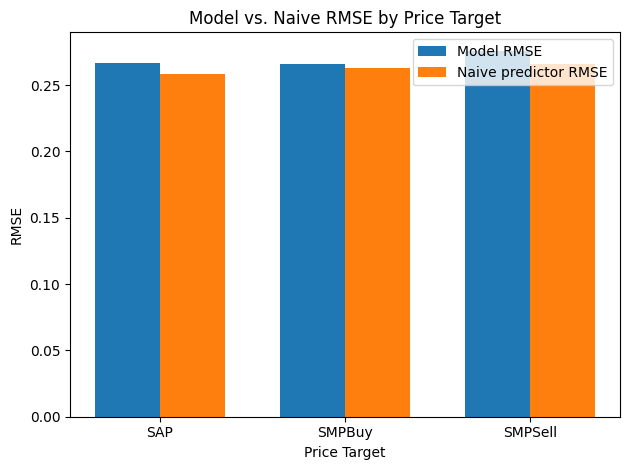

In [110]:
X_test = get_X(test)
model_rmses = []
naive_rmses = []
for pt in price_targets:
    file_path = models_dir / f"{pt}_best_rf.joblib"
    model = joblib.load(file_path)
    y_test = get_y(test, pt)
    model_rmse = validate_model(model, X_test, y_test)
    model_rmses.append(model_rmse)
    naive_rmse = naive_predictions(test, pt)
    naive_rmses.append(naive_rmse)


x = range(len(price_targets))
width = 0.35

fig, ax = plt.subplots()
ax.bar([i - width/2 for i in x], model_rmses, width, label='Model RMSE')
ax.bar([i + width/2 for i in x], naive_rmses, width, label='Naive predictor RMSE')

ax.set_xlabel('Price Target')
ax.set_ylabel('RMSE')
ax.set_title('Model vs. Naive RMSE by Price Target')
ax.set_xticks(x)
ax.set_xticklabels(price_targets)
ax.legend()

plt.tight_layout()
plt.show()